<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [21]:
import pandas as pd

yelp = pd.read_json('./data/review_sample.json', lines=True)

In [22]:
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


In [80]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# stopword
import nltk; nltk.download('stopwords')

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/connorheraty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
yelp['text'][0]

'BEWARE!!! FAKE, FAKE, FAKE....We also own a small business in Los Alamitos, CA and received what looked like a legitimate bill for $70 with an account number and all.  I called the phone number listed (866) 273-7934.  The wait time on hold said 20 minutes and to leave a message.  I could not get a live person on the phone no matter what number I selected.  I left a very FIRM message that I would be contacting the BBB and my attorney regarding their company trying to scam businesses. This has to be illegal!!!!!'

## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

### Tokenization

In [25]:
def tokenize(docs):
    
    for doc in docs:
        yield(gensim.utils.simple_preprocess(str(doc), deacc=True))

In [26]:
data_words = list(tokenize(yelp['text']))

In [42]:
data_list = []
for doc in data_words:
    new_doc = [token.lower() for token in doc]
    data_list.append(new_doc)

In [44]:
yelp['tokens'] = data_list

### Remove Stopwords

In [107]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend([' ', '\n', '\n\n'])

In [28]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(texts)) if word not in stop_words] for doc in texts]

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

### TF-IDF Vectorization

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, lowercase=False, tokenizer=lambda x:x)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(yelp['tokens'])

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Nearest Neighbor Modeling

In [50]:
# Instantiate
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')

# Fit on TF-IDF Vectors
nn.fit(dtm.todense())

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=10, p=2, radius=1.0)

### Fake Review

In [59]:
# Fake Review Example
# Overtly negative to test efficacy of model
new = tfidf.transform(['I Absolutely hate hate hate this restaurant. The service is horrible and the food stinks! I do NOT recommend ever going to this stupid horrible restaurant. I would rather die of starvation then ever eat at this horrible terrible no good place ever again.'])

nn.kneighbors(new.todense())

(array([[0., 0., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[6204, 6311, 2015, 3650, 6411,   22, 2773,  198, 4090, 1077]]))

In [150]:
# Similar review with a clearly negative spin
yelp['text'][4090]

"I have a love hate relationship with this buffet...sometimes I come out feeling that was a good meal...other times I felt wow that could have been better. The last few times has been the latter. For one, I take the quality is just going down. I think compared to everywhere else, they do have the different choices with the exception of the pizza and the meats and breakfast, but that's just it. It used to be my go to buffet but it hasn't been for awhile.\n\nI don't know if it's just the Wynn but wth? The second to the last time I went my friend showed up with a muscle shirt and he wasn't let in because they have this no sleeveless shirt for guys policy in the buffet? Really it's freaking 100 degrees outside and you expect him to wear a shirt with sleeves? This isn't fine dining, it's a freaking buffet and it was 3 o'clock in the afternoon. What happens if we waited in line for an hour and then by time we get to the front you turned us away? that wouldn't have been nice at least it was q

In [64]:
# Not sure of the connection here...
yelp['text'][6204]

'旅行でラスベガスに来ましたがネイルがはげてるのが気になり、探したお店でした。\n質問にも丁寧に答えてくれましたし、日本人の方も日本語が話せる方も居て、とても綺麗で居心地のいいお店でした。 \nネイルはちはるさんと言う綺麗な方が丁寧にしてくれとても気に入りました。\n予定になかったまつ毛エクステもお願いし、日本ではまだあまりないブラウンカラーのエクステをしてもらい、とても気に入りました。\nまた是非マッサージなどで伺いたいと思います。'

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [72]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Instantiate Pipline Object
vect=TfidfVectorizer(stop_words='english')
sgdc = SGDClassifier()
pipeline = Pipeline([
    ('vect',vect),
    ('clf', sgdc)
])

In [73]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
#    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
#    'tfidf__use_idf': (True, False),
#    'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
#    'clf__max_iter': (10, 50, 80),
}

In [74]:
features = 'text'
target = 'stars'

In [75]:
grid_search = GridSearchCV(pipeline, parameters, cv=5,
                          n_jobs=-1,verbose=1)


grid_search.fit(yelp[features],yelp[target])
print('best score: %0.3f'% grid_search.best_score_)
print('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.7min finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


best score: 0.568
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 20
	clf__penalty: 'elasticnet'
	vect__max_df: 0.75
	vect__max_features: 50000


## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [139]:
import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load("en_core_web_sm")

In [140]:
tokenizer = Tokenizer(nlp.vocab)

STOPWORDS = stop_words
tokens = []

for doc in tokenizer.pipe(yelp['text'], batch_size=500):
    doc_tokens = [token.text.lower() for token in doc if token.text.lower() not in STOPWORDS]
    tokens.append(doc_tokens)
    
yelp['tokens'] = tokens

In [161]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [163]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(yelp['tokens'], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['beware', 'fake', 'fake', 'fake', 'also', 'small', 'business', 'los', 'alamito', 'ca', 'receive', 'look', 'legitimate', 'bill', 'account', 'number', 'call', 'phone', 'number', 'list', 'wait', 'time', 'hold', 'say', 'minute', 'leave', 'message', 'could', 'get', 'live', 'person', 'phone', 'matter', 'number', 'select', 'leave', 'firm', 'message', 'would', 'contact', 'bbb', 'attorney', 'regard', 'company', 'try', 'scam', 'business', 'illegal']]


In [164]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(data_lemmatized)

In [165]:
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

In [176]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 8,
                   passes=10,
                   workers=4
                  )

In [177]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [178]:
topics = [' '.join(t[0:3]) for t in words]

### Compute Coherence and Model Perplexity

In [179]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.678385819391319

Coherence Score:  0.35777577432800395


### Computing Multiple Coherence Values to determine optimal number of Topics

In [180]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [181]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

### Optimal Coherence Values Visualization

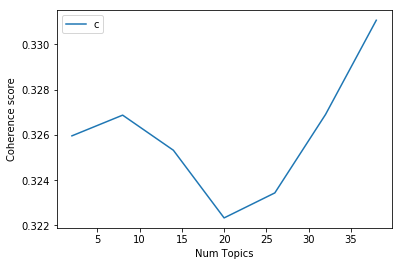

In [182]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Topic Modeling Visualization

In [183]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.130951  0.013366       1        1  34.834743
2      0.111478  0.040149       2        1  16.794643
7      0.003887 -0.032441       3        1  12.079030
4     -0.055318  0.027998       4        1  10.294994
0      0.082467  0.049123       5        1   8.760829
3     -0.110709  0.008509       6        1   7.371805
5      0.042567 -0.134004       7        1   4.980876
6      0.056579  0.027300       8        1   4.883082, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
151   Default  4934.000000        food  4934.000000  30.0000  30.0000
381   Default  3237.000000       order  3237.000000  29.0000  29.0000
138   Default  5167.000000       place  5167.000000  28.0000  28.0000
78    Default  5524.000000          go  5524.000000  27.0000  27.0000
43    Default  6073.000000        good  6073.000000  26.0000  26.0000
196   Default   485.000000        taco   485.000000  25.0000  25.0000
49    Default  3734.000000     service  3734.000000  24.0000  24.0000
220   Default  4257.000000       great  4257.000000  23.0000  23.0000
126   Default  4032.000000          be  4032.000000  22.0000  22.0000
15    Default  6100.000000         get  6100.000000  21.0000  21.0000
9     Default  1346.000000        call  1346.000000  20.0000  20.0000
57    Default  1073.000000         bar  1073.000000  19.0000  19.0000
109   Default  1188.000000        room  1188.000000  18.0000  18.0000
852   Default   674.000000      burger   674.000000  17.0000  17.0000
32    Default  2502.000000         say  2502.000000  16.0000  16.0000
88    Default  2938.000000        make  2938.000000  15.0000  15.0000
36    Default  4256.000000        time  4256.000000  14.0000  14.0000
155   Default  1142.000000         fry  1142.000000  13.0000  13.0000
755   Default   752.000000         car   752.000000  12.0000  12.0000
39    Default  3038.000000       would  3038.000000  11.0000  11.0000
188   Default  1266.000000        menu  1266.000000  10.0000  10.0000
221   Default   345.000000        hair   345.000000   9.0000   9.0000
331   Default  1452.000000        work  1452.000000   8.0000   8.0000
666   Default   608.000000        beer   608.000000   7.0000   7.0000
1154  Default  1421.000000     chicken  1421.000000   6.0000   6.0000
298   Default   343.000000        nail   343.000000   5.0000   5.0000
150   Default  1497.000000         eat  1497.000000   4.0000   4.0000
394   Default   874.000000      server   874.000000   3.0000   3.0000
38    Default  1647.000000        wait  1647.000000   2.0000   2.0000
237   Default  1584.000000         see  1584.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
331    Topic8   134.030151        work  1452.746826   0.6362  -5.2831
1281   Topic8    83.052689        care   647.716370   0.9654  -5.7617
414    Topic8   121.742432         ask  1407.389526   0.5718  -5.3792
39     Topic8   177.756287       would  3038.070557   0.1808  -5.0007
494    Topic8   121.781288        tell  1506.249878   0.5042  -5.3789
472    Topic8   122.592072         not  1592.583496   0.4551  -5.3723
15     Topic8   224.163818         get  6100.862305  -0.2844  -4.7688
243    Topic8    74.158234       thank   582.375244   0.9585  -5.8749
78     Topic8   211.668594          go  5524.167969  -0.2425  -4.8261
220    Topic8   184.032562       great  4257.474609  -0.1219  -4.9660
22     Topic8   127.391388        look  1917.598877   0.3078  -5.3339
315    Topic8   119.739487        want  1730.012573   0.3488  -5.3958
456    Topic8   112.926109        know  1689.150635   0.3141  -5.4544
193    Topic8   134.980026      really  2585.543945   0.0668  -5.2760
138    Topic8   173.211990       place  5167.249023  -0.3762  -5.0266
95     Topic8   102.785561       never  1431.340820   0.3

### Finding the dominant topic for each review

In [184]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [215]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=yelp['tokens'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.8270,"get, go, time, call, say, take, would, tell, c...","[beware!!!, fake,, fake,, fake....we, also, sm..."
1,1,7.0,0.6368,"get, place, good, be, go, room, great, come, n...","[came, lunch, togo., service, quick., staff, f..."
2,2,2.0,0.5699,"get, go, time, call, say, take, would, tell, c...","[i've, vegas, dozens, times, never, stepped, f..."
3,3,7.0,0.3849,"get, place, good, be, go, room, great, come, n...","[went, night, closed, part, street, party..., ..."
4,4,1.0,0.9474,"good, food, place, great, get, go, order, come...","[3.5, 4, stars, bad, price,, $12.99, lunch,, s..."
5,5,1.0,0.7157,"good, food, place, great, get, go, order, come...","[tasty,, fast, casual, latin, street, food., m..."
6,6,7.0,0.3770,"get, place, good, be, go, room, great, come, n...","[show, absolutely, amazing!!, incredible, prod..."
7,7,1.0,0.9648,"good, food, place, great, get, go, order, come...","[came, pho, really, enjoyed, it!, got, 9:00pm,..."
8,8,0.0,0.7125,"go, time, get, be, make, say, back, great, hai...","[absolutely, unique, experience, nail, shop, f..."
9,9,4.0,0.5729,"food, service, place, order, good, go, come, g...","[wow., walked, sat, bar, 10, minutes., bartend..."


In [220]:
pd.set_option('display.max_colwidth', 1000)

In [225]:
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 1.0].Keywords.head(1)

4    good, food, place, great, get, go, order, come, try, time
Name: Keywords, dtype: object

In [227]:
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 1.0].Text.head(5)

4                                                                                                                                                                                                                                                                                                                                                                                            [3.5, 4, stars, bad, price,, $12.99, lunch,, seniors, get, 15%, off., pay, front, eating., hot, food,, salads,, noodle, bar,, dessert,, fruits,, fried, varieties, soup., seating, middle, section, bit, tight,, booths, side, look, spacious., think, lunch, noodle, bar, would, variety, different, types, greens,, vermicelli, noodles,, frozen, tofu,, etc., tomato, laksa, broth, pretty, good.]
5                                                                                                                                                                                                                                    

In [226]:
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 2.0].Keywords.head(1)

0    get, go, time, call, say, take, would, tell, car, come
Name: Keywords, dtype: object

In [229]:
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 2.0].Text.head(5)

0                                                                                                                                                                                                                                                                                                                                                                                  [beware!!!, fake,, fake,, fake....we, also, small, business, los, alamitos,, ca, received, looked, like, legitimate, bill, $70, account, number, all., called, phone, number, listed, (866), 273-7934., wait, time, hold, said, 20, minutes, leave, message., could, get, live, person, phone, matter, number, selected., left, firm, message, would, contacting, bbb, attorney, regarding, company, trying, scam, businesses., illegal!!!!!]
2     [i've, vegas, dozens, times, never, stepped, foot, circus, circus., one, reason, mostly,, resort, marketed, familes, travel, vegas,, business, twenty-three, year, old, circus, circus?, well,, n

In [230]:
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 3.0].Keywords.head(1)

41    order, good, get, taco, food, go, make, be, burger, come
Name: Keywords, dtype: object

In [231]:
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 3.0].Text.head(5)

41    [handel's, great, place, get, homemade, ice, cream,, even, middle, snowstorm, (which, went)., location, intersection, 82, &, 176., one, thing, stands, handel's, order, outside., thing, inside, buildings, ice, cream, made., that's, makes, stand, went, snowstorm., worth, though., tons, flavors,, many, creative., ordered, black, raspberry, really, enjoyed, it., say, quite, good, black, raspberry, ice, cream, vermont,, different,, i'm, including, rating., bonus,, dog, you,, get, free, "doggie, cone", really, small, cone, vanilla, ice, cream, it., overall,, looking, great, ice, cream, northeast, ohio, well, couple, areas, around, country,, stop, handel's., regret, calories.]
58                                                                                                                                                                                                                                                                                                                         

## Results Analysis

Overall I am pleased with the results of my analysis. The following is an example of what I have found: <br> <br>

**Topic 1 Keywords** `good, food, place, great, get, go, order, come, try, time` <br>
My LDA model appears to identify Topic 1 as positive restaurant reviews. This is not surprising as restaraunt reviews comprise a large share of all reviews on yelp. Common reviews identified in Topic 1 words describing various food items often using descriptive adjectives. Topic one contains the greatest amount of reviews and is positioned the farthest distance away from Topic 2. <br><br>

**Topic 2 Keywords** `get, go, time, call, say, take, would, tell, car, come` <br>
The model appears to identify topic 2 as comprising of negative reviews. This intuitively makes sense when looking at the pyLDAvis graph as it is juxtaposed at opposite ends with Topic 1. Topic 2 appears to contain numerous reviews describing disgruntled customer experiences. <br><br>

**Topic 3 Keywords** `order, good, get, taco, food, go, make, be, burger, come` <br>
Topic 3 largely contains reviews that are neither overtly positive or negative. Reading some of the reviews that fall in to topic 3 reveal a reviewer that has a decent customer experience with a few hangups. When looking at the pyLDAvis graph, Topic 3 falls in the middle between Topic 1 and Topic 2. This is consistent with my analysis. 

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)